# Machine Learning Challenge

## Overview

The focus of this exercise is on a field within machine learning called [Natural Language Processing](https://en.wikipedia.org/wiki/Natural-language_processing). We can think of this field as the intersection between language, and machine learning. Tasks in this field include automatic translation (Google translate), intelligent personal assistants (Siri), information extraction, and speech recognition for example.

NLP uses many of the same techniques as traditional data science, but also features a number of specialised skills and approaches. There is no expectation that you have any experience with NLP, however, to complete the challenge it will be useful to have the following skills:

- understanding of the python programming language
- understanding of basic machine learning concepts, i.e. supervised learning


### Instructions

1. Download this notebook!
2. Answer each of the provided questions, including your source code as cells in this notebook.
3. Share the results with us, e.g. a Github repo.

### Task description

You will be performing a task known as [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, we consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

Each file can be found in the `input` directory, and contains 1000 rows of data. Each row contains a sentence, a `tab` character and then a label -- `0` or `1`. 

**Notes**
- Feel free to use existing machine learning libraries as components in you solution!
- Suggested libraries: `sklearn` (for machine learning), `pandas` (for loading/processing data), `spacy` (for text processing).
- As mentioned, you are not expected to have previous experience with this exact task. You are free to refer to external tutorials/resources to assist you. However, you will be asked to justfify the choices you have made -- so make you understand the approach you have taken.

In [1]:
import os
print(os.listdir("./input"))

['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']


# Tasks
### 1. Read and concatenate data into test and train sets.

Combine all review data into two Pandas Data Frames representing the train and test datasets

In [2]:
import pandas as pd

# Set path to the data files
path = './input/'

# Add column names
col_names = ['Text', 'Label']

# Import data files as Pandas Dataframes
df_yelp = pd.read_table(path+'yelp_labelled.txt', names=col_names)
df_amazon = pd.read_table(path+'amazon_cells_labelled.txt', names=col_names) # Use as test dataset
df_imdb = pd.read_table(path+'imdb_labelled.txt', names=col_names)

# Combine/union Yelp and IMDB into a single dataframe
df_comb = pd.concat([df_yelp, df_imdb])    # Use as train data set


In [3]:
# Combine all three datasets into one and use for alternative testing

df_all = pd.concat([df_yelp, df_imdb, df_amazon])

### 2. Prepare the data for input into your model.

In [4]:
# Checking for Missing Values
df_comb.isnull().sum()

Text     0
Label    0
dtype: int64

**Lemmatize and remove stop words from the obtained dataset.**

**Tokenization** is the process of breaking text into pieces, called tokens, and ignoring characters like punctuation marks (,. “ ‘) and spaces. spaCy‘s tokenizer takes input in form of unicode text and outputs a sequence of token objects.

In [5]:
from  spacy.lang.en.stop_words import STOP_WORDS
# Build a list of stopwords to use to filter
stopwords = list(STOP_WORDS)

import en_core_web_sm
nlp = en_core_web_sm.load()

import string
punctuations = string.punctuation

def my_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [6]:
# Example of tekonizer
my_tokenizer("This is how John Walker was walking. He was also running beside the lawn.")

['john', 'walker', 'walk', 'run', 'lawn']

In [7]:
# Example 2 of tokenizer
my_tokenizer("I go to far too many places and I've never seen any restaurant that serves a 1 egg breakfast, especially for $4.00.")

['far',
 'place',
 'restaurant',
 'serve',
 '1',
 'egg',
 'breakfast',
 'especially',
 '4.00']

#### 2a: Find the ten most frequent words in the training set.

In [8]:
df_comb['Tokenised Text'] = df_comb['Text'].apply(lambda x: my_tokenizer(x)).apply(lambda x: ' '.join(x))

df_comb.head()

,Text,Label,Tokenised Text
0,Wow... Loved this place.,1,wow ... love place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stop late bank holiday rick steve recommendati...
4,The selection on the menu was great and so wer...,1,selection menu great price


In [17]:
#List top 10 most frequent words
words = pd.Series(' '.join(df_comb['Tokenised Text']).split()).value_counts()[:10]

words

movie    212
good     201
film     189
0        138
food     127
bad      126
1        124
place    119
great    115
like     111
dtype: int64

### 3. Train your model and justify your choices.

In [10]:
# ML Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [11]:
# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()

#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
# Vectorization
vectorizer = CountVectorizer(tokenizer = my_tokenizer, ngram_range=(1,1)) 

# Select Linear Support Vector Classification 
classifier = LinearSVC()

In [12]:
# Select Train and Test datasets and split into text and labels
X_train = df_comb['Text']
y_train = df_comb['Label']

X_test = df_amazon['Text']
y_test = df_amazon['Label']


In [13]:
# Create the  pipeline to clean, tokenize, vectorize, and classify using"Count Vectorizor"
pipe_countvect = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Fit our data - Fit the model according to the given training data.
pipe_countvect.fit(X_train,y_train)


# Predicting with a test dataset - Predict class labels for samples in X.
sample_prediction = pipe_countvect.predict(X_test)

# Print Prediction Results
# 1 = Positive review
# 0 = Negative review
# for (sample,pred) in zip(X_test,sample_prediction):
#     print(sample,"Prediction=>",pred)



### 4. Evaluate your model using metric(s) you see fit and justify your choices.

In [14]:
# Results - Accuracy - Balanced Problem
#Return the mean accuracy on the given test data and labels.

print("Training Accuracy: ", pipe_countvect.score(X_train, y_train))
print("Test Accuracy: ", pipe_countvect.score(X_test, y_test))

Training Accuracy:  0.9856979405034325
Test Accuracy:  0.75


### Additional Notes on Accuracy:


To fully evaluate the effectiveness of a model, you must examine both **precision** and **recall**.

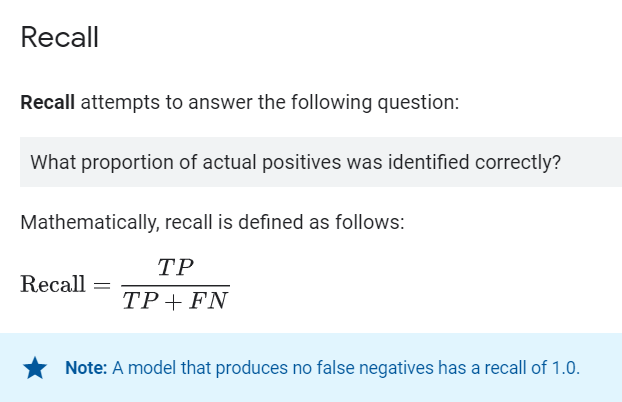

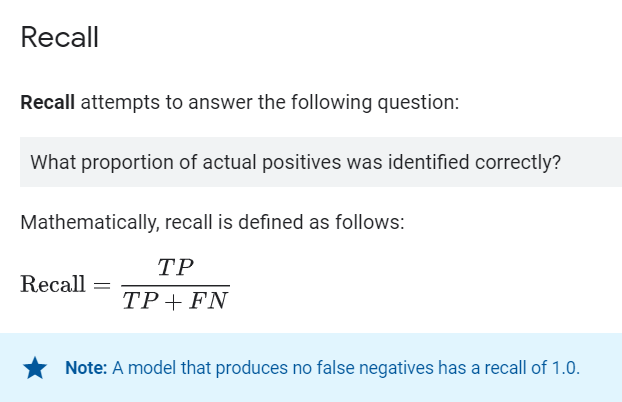

### 5. Evaluate alternative train/test model using all datasets combined and using 80-20 split

In [15]:
# Splitting Data Set
from sklearn.model_selection import train_test_split

# Features and Labels
X = df_all['Text']
ylabels = df_all['Label']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [16]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Fit our data
pipe.fit(X_train,y_train)

# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)

# Accuracy
print("Train Accuracy: ",pipe.score(X_train,y_train))
print("Test Accuracy: ",pipe.score(X_test,y_test))

Train Accuracy:  0.9763421292083713
Test Accuracy:  0.7672727272727272
